<a href="https://colab.research.google.com/github/wonyoung-ji/asiae_edu/blob/master/fintech/200918_%EB%84%A4%EC%9D%B4%EB%B2%84_DataLab_CJ_ENM_%EC%A3%BC%EA%B0%80_shift_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __네이버 데이터랩과 주가분석__
  - 검색어 트렌드 분석을 통해 검색어 증가에 따른 주가변동을 분석한다.
  - 마케팅 효과에 따른 검색어 증가량의 변동을 분석한다.
  - 검색어 증가를 통해 마케팅의 수명은 어느정도인지 관리한다.
  - 경쟁사의 검색어 데이터를 통해 경쟁사 마케팅의 파급효과를 분석한다.
  - reference: https://developers.naver.com/docs/datalab/search/#python

# 1.라이브러리 설치

In [ ]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import json
import os
import sys
import urllib.request

# 2.네이버 DataLab 검색량 추출 함수 정의

In [ ]:
nid= '52vIBt7gRjMAHREje_XB'
nkey= 'BNbzV6Ygv6'

## 2.1. makeQry 함수 정의
- 검색량 추출을 위한 body를 정의하는 함수

In [ ]:
def makeQry(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date'):
  res=[]
  for words in keywords:
    dict = {'groupName':words[0],'keywords':words}
    res.append(dict)
  rdict = {"startDate":sday,
    "endDate":eday,
    "timeUnit":tunit,
    "keywordGroups":res
    }
  return json.dumps(rdict,ensure_ascii=False)         #  Python의 객체를 JSON 문자열로 변환

## 2.2. Mysearch 함수 정의
- 검색량을 출력하는 함수

In [ ]:
def Mysearch(keywords=[], sday='2019-01-01',eday='2020-08-30',tunit='date'):
  client_id = nid
  client_secret = nkey 
  url = "https://openapi.naver.com/v1/datalab/search";
 
  body= makeQry(keywords,sday,eday,tunit)
  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()

  if (rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    # print(res)
  else:
    res='error'
    print("Error Code:" + rescode)
  return res

## 2.3. MyDataLab 함수 정의
- 다중 키워드의 검색량을 데이터 프레임으로 병합시키는 함수

In [ ]:
def MyDataLab(keywords,sday='2019-01-01',eday='2020-08-30',tunit='date'):
  res = Mysearch(keywords,sday, eday, tunit)
  jdata = json.loads(res)
  i = 0
  maindf = pd.DataFrame()
  for words in keywords:
    pdata = jdata['results'][i]['data']
    df = pd.DataFrame.from_dict(pdata)
    df.columns=['period',words[0]]
    df = df.set_index('period')
    maindf = pd.merge(maindf,df,how='outer',left_index=True,right_index=True)
    i+=1
  return maindf

# 3.CJ ENM 주가분석

## 3.1. CJ ENM 주식데이터 가져오기
- BigQuery에 있는 데이터를 불러온다

In [ ]:
import pandas as pd
from pandas.io import gbq

project_id = 'decisive-clover-286903'
sql = """
    SELECT SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL
    FROM `NaverStock.CJENM`
    Where SDAY >= 20190101 and SDAY <= 20200830
    ORDER BY SDAY asc
    """
cjenm = pd.read_gbq(sql, project_id=project_id, dialect='standard')
cjenm.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL
0,20190102,202700.0,202900.0,196500.0,196500.0,58208.0
1,20190103,196700.0,197500.0,190200.0,191200.0,69363.0
2,20190104,191200.0,192500.0,187400.0,191500.0,70378.0
3,20190107,192600.0,199400.0,192200.0,199400.0,64370.0
4,20190108,199500.0,200100.0,195600.0,195800.0,38965.0


## 3.2. CJ ENM의 주식과 검색량의 관계
- 2019.01.01 ~ 2020.08.30 주식을 가져온다.
- 동일한 기간의 네이버 데이터랩 검색량을 불러온다
- 위 둘을 합친다

In [ ]:
cjenm['period'] = [str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in cjenm['SDAY']]
cjenm = cjenm.set_index('period')
cjenm.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL
period,,,,,,
2019-01-02,20190102,202700.0,202900.0,196500.0,196500.0,58208.0
2019-01-03,20190103,196700.0,197500.0,190200.0,191200.0,69363.0
2019-01-04,20190104,191200.0,192500.0,187400.0,191500.0,70378.0
2019-01-07,20190107,192600.0,199400.0,192200.0,199400.0,64370.0
2019-01-08,20190108,199500.0,200100.0,195600.0,195800.0,38965.0


In [ ]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
mdf = MyDataLab(keywords,'2019-01-01','2020-08-30','date')
mdf.head()

,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,
2019-01-01,0.51273,0.03758,0.01178,0.15669,0.14547
2019-01-02,0.59014,0.03655,0.01355,0.14220,0.11658
2019-01-03,0.57528,0.02870,0.00981,0.11350,0.10892
2019-01-04,5.09767,0.02758,0.01552,0.12453,0.10172
2019-01-05,1.13232,0.03300,0.01299,0.14248,0.08695


In [ ]:
alldf = pd.merge(cjenm,mdf,how='outer',left_index=True, right_index=True)
alldf.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.51273,0.03758,0.01178,0.15669,0.14547
2019-01-02,20190102.0,202700.0,202900.0,196500.0,196500.0,58208.0,0.59014,0.03655,0.01355,0.14220,0.11658
2019-01-03,20190103.0,196700.0,197500.0,190200.0,191200.0,69363.0,0.57528,0.02870,0.00981,0.11350,0.10892
2019-01-04,20190104.0,191200.0,192500.0,187400.0,191500.0,70378.0,5.09767,0.02758,0.01552,0.12453,0.10172
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1.13232,0.03300,0.01299,0.14248,0.08695


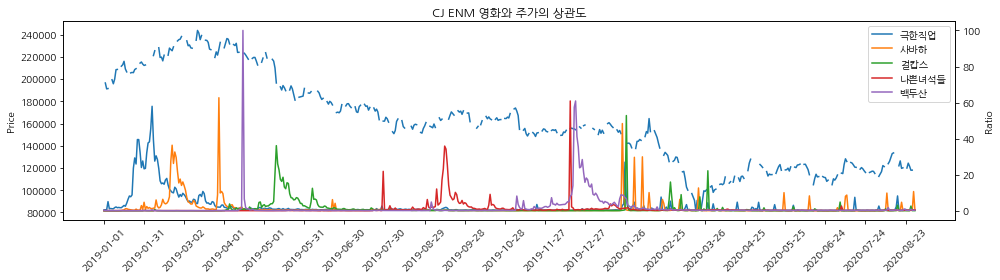

In [ ]:
import numpy as np

setdf = alldf[['극한직업','사바하','걸캅스','나쁜녀석들','백두산']]
setdf.head()

xtic = np.arange(0, len(alldf.index), step=30)
xdays = [ alldf.index[i] for i in xtic]

plt.rcParams["figure.figsize"] = (14,4)
fig, ax1 = plt.subplots()
plt.xticks(xtic, rotation=45)

ax1.plot(alldf['CLOSEP'])
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.set_ylabel('Ratio')
setdf.plot(ax=ax2)
plt.title('CJ ENM 영화와 주가의 상관도')
fig.tight_layout()

alldf.interpolate()
plt.show()

# 4.MyDBLab 함수 정의
- 원하는 회사의 주식데이터와 검색량데이터를 합치는 함수

In [ ]:
def MyDBLab(keywords=[],sday='2019-01-01',eday='2020-08-30',tunit='date',sname='CJENM'):
  # 네이버DataLab 검색량 데이터 추출
  mdf=MyDataLab(keywords, sday ,eday, tunit)

  # 쿼리문 대입하기 위해 문자열 수정
  sdaycode = sday.replace('-','')
  edaycode = eday.replace('-','')

  # SQL문 생성
  whsrc = 'SELECT SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL FROM `NaverStock.{}` Where SDAY >= {} and SDAY <= {} ORDER BY SDAY asc'
  sql = whsrc.format(sname, sdaycode, edaycode)

  # 빅쿼리에서 주식데이터 추출 후 정제
  df = pd.read_gbq(sql, project_id=project_id, dialect='standard')
  df['period'] = [str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in df['SDAY']]
  dfstock = df.set_index('period')

  # (주식데이터) + (네이버 DataLab 검색량 데이터)
  alldf = pd.merge(dfstock,mdf,how='outer',left_index=True, right_index=True)

  #선형보간
  alldf= alldf.interpolate()

  return alldf

- MyDBLab 함수를 이용하여 데이터 추출 및 시각화

In [ ]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
alldf = MyDBLab(keywords,'2019-01-01','2020-08-30','date','CJENM')
alldf.head()

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.51273,0.03758,0.01178,0.15669,0.14547
2019-01-02,20190102.0,202700.000000,202900.0,196500.0,196500.000000,58208.000000,0.59014,0.03655,0.01355,0.14220,0.11658
2019-01-03,20190103.0,196700.000000,197500.0,190200.0,191200.000000,69363.000000,0.57528,0.02870,0.00981,0.11350,0.10892
2019-01-04,20190104.0,191200.000000,192500.0,187400.0,191500.000000,70378.000000,5.09767,0.02758,0.01552,0.12453,0.10172
2019-01-05,20190105.0,191666.666667,194800.0,189000.0,194133.333333,68375.333333,1.13232,0.03300,0.01299,0.14248,0.08695


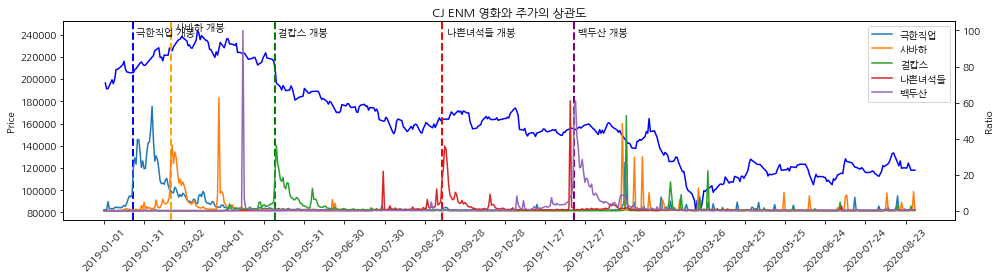

In [ ]:
plt.rcParams["figure.figsize"] = (14,4)
fig, ax1 = plt.subplots()

# 주가 그래프
ax1.plot(alldf['CLOSEP'],c='b')

ax1.axvline(x='2019-01-23',label='극한직업 개봉', c="b", linestyle='--',  linewidth=2)         # 극한직업 개봉일 2019년 1월 23일
plt.text(24,240000,"극한직업 개봉")
ax1.axvline(x='2019-02-20',label='사바하 개봉',color='orange',linestyle='--',  linewidth=2)    # 사바하 개봉일 2019년 2월 20일
plt.text(53,245000,"사바하 개봉")
ax1.axvline(x='2019-05-09',label='걸캅스 개봉',color='green',linestyle='--',  linewidth=2)     # 걸캅스 개봉일 2019년 5월 9일
plt.text(130,240000,"걸캅스 개봉")
ax1.axvline(x='2019-09-11',label='나쁜녀석들 개봉',c='r',linestyle='--',  linewidth=2)         # 나쁜녀석들 개봉일 2019년 9월 11일
plt.text(257,240000,"나쁜녀석들 개봉")
ax1.axvline(x='2019-12-19',label='백두산 개봉',color='purple',linestyle='--',  linewidth=2)    # 백두산 개봉일 2019년 12월 19일
plt.text(355,240000,"백두산 개봉")
ax1.set_ylabel('Price')
plt.xticks(xtic, rotation=45)

# 네이버 DataLab 검색량 그래프
ax2 = ax1.twinx()
ax2.set_ylabel('Ratio')
setdf.plot(ax=ax2)

# 그래프 레이아웃 설정
plt.title('CJ ENM 영화와 주가의 상관도')
fig.tight_layout()
plt.show()

# 5.PltDBLab 함수 정의
- MyDBLab을 바탕으로 시각화한다

In [ ]:
def PltDBLab(alldf, keywords, xstep=10, ptitle='CJ ENM 영화와 주가의 상관도',axvpos='2019-01-01'):

  xtic = np.arange(0, len(alldf.index), step=xstep)
  xdays = [ alldf.index[i] for i in xtic ]
  set_df=pd.DataFrame()
  for words in keywords:
    set_df=pd.concat((set_df, alldf[words]), axis=1)

  plt.rcParams["figure.figsize"] = (16,8)
  fig, ax1 = plt.subplots()

  # 주가 그래프
  ax1.plot(alldf['CLOSEP'],c='b')
  pos=axvpos
  ax1.axvline(x=pos,label='개봉', c="b", linestyle='--',  linewidth=2) 
  ax1.set_ylabel('Price')
  plt.xticks(xtic, rotation=45)

  # 네이버 DataLab 검색량 그래프
  ax2 = ax1.twinx()
  ax2.set_ylabel('Ratio')
  set_df.plot(ax=ax2)

  # 그래프 레이아웃 설정
  plt.title(ptitle, fontdict={'fontsize':20})
  fig.tight_layout()
  plt.show()

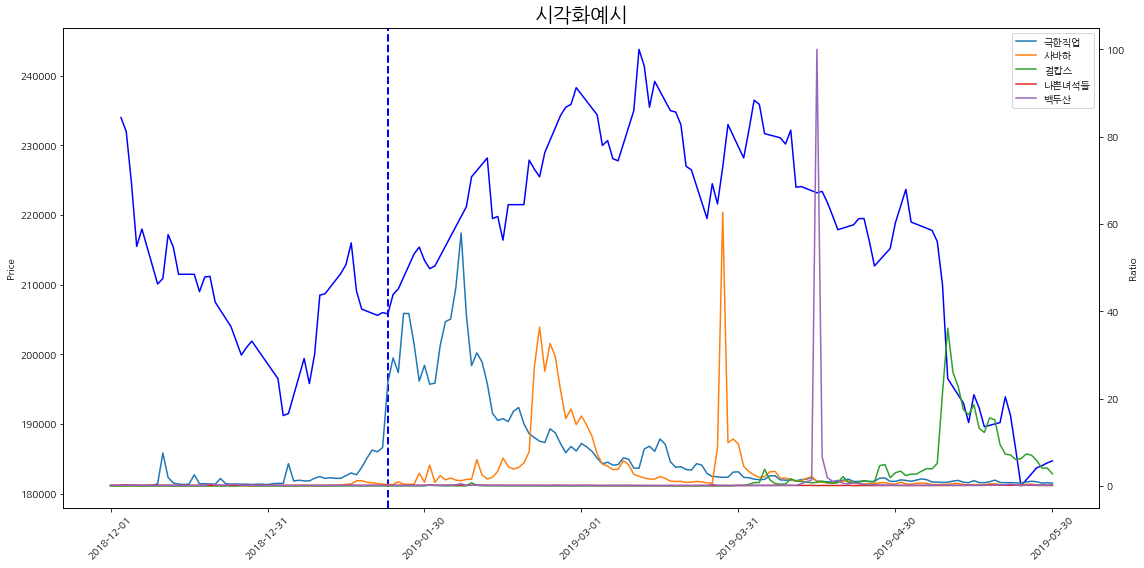

In [ ]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
alldf = MyDBLab(keywords,'2018-12-01','2019-05-30','date','CJENM')
PltDBLab(alldf,keywords,30,'시각화예시','2019-01-23')

# 6.영화개봉이 주가에 주는 영향 분석 예시

## 6.1. 영화검색량과 주가의 상관관계
- 극한직업을 예시로 든다.
- 통계량 분석: 피어슨 상관계수(Pearson Correlation Coefficient, PCC)
  + 두 변수 X와 Y간의 선형 상관 관계를 계량화한 수치
  + 피어슨 상관계수는 코시-슈바르츠 부등식에 의해 -1과 +1 사이의 값을 가짐
  + +1: 완벽한 양의 선형 상관관계
  + 0: 선형 상관관계 없음
  + -1: 완벽한 음의 선형 상관관계

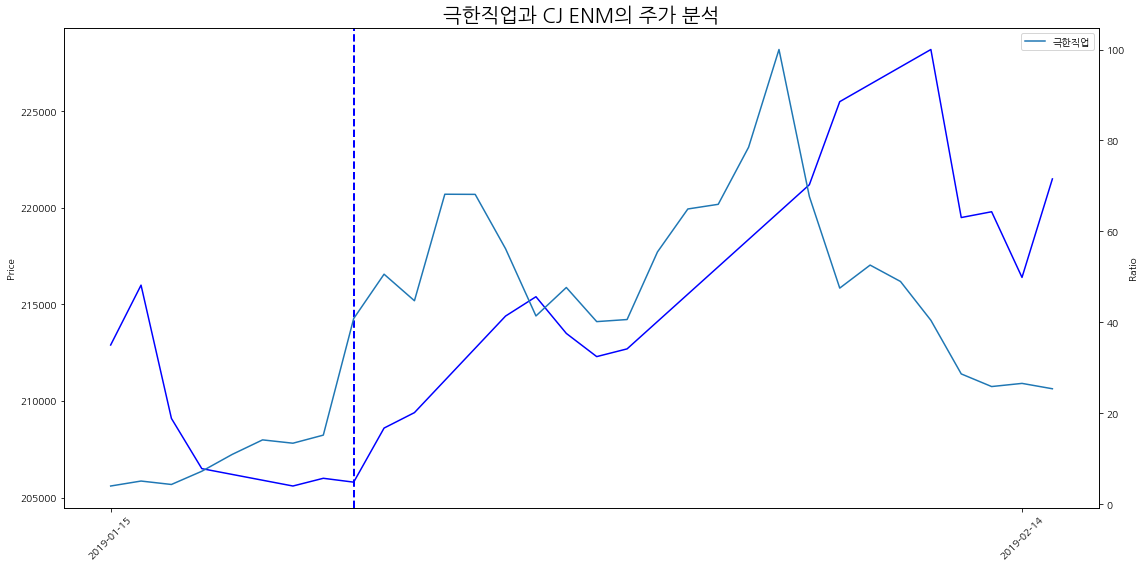

In [ ]:
keywords = [['극한직업']]
movie_df = MyDBLab(keywords,'2019-01-15','2019-02-15','date','CJENM')
PltDBLab(movie_df, keywords, xstep=30, ptitle='극한직업과 CJ ENM의 주가 분석',axvpos='2019-01-23')

In [ ]:
checkdf = movie_df[['CLOSEP','극한직업']]
checkdf.corr()

,CLOSEP,극한직업
CLOSEP,1.000000,0.390641
극한직업,0.390641,1.000000


 - 상관계수가 40%로 낮게 나왔다.
 - 그러나 peak가 비슷한 곳에 있는 걸 보니, shift가 걸려있다고 추측했다.

## 6.2. shift 설정
- 5일을 shift로 걸어준 후 상관관계를 분석한다.



In [ ]:
checkdf.columns=['CLOSEP','shift5']
shiftdf=checkdf['shift5'].shift(5,fill_value=0)
shiftdf.head(10)

period
2019-01-15     0.00000
2019-01-16     0.00000
2019-01-17     0.00000
2019-01-18     0.00000
2019-01-19     0.00000
2019-01-20     4.04935
2019-01-21     5.14039
2019-01-22     4.38706
2019-01-23     7.29230
2019-01-24    10.99330
Name: shift5, dtype: float64

In [ ]:
shiftall=pd.merge(movie_df,shiftdf,how="inner",left_index=True,right_index=True)
shiftall.head(10)

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,shift5
period,,,,,,,,
2019-01-15,20190115.0,211400.000000,212900.000000,208400.0,212900.0,54176.000000,4.04935,0.00000
2019-01-16,20190116.0,213000.000000,217600.000000,211200.0,216000.0,82763.000000,5.14039,0.00000
2019-01-17,20190117.0,214800.000000,215300.000000,205800.0,209100.0,66824.000000,4.38706,0.00000
2019-01-18,20190118.0,208500.000000,208500.000000,202500.0,206500.0,74195.000000,7.29230,0.00000
2019-01-19,20190119.0,207633.333333,208366.666667,203100.0,206200.0,66475.333333,10.99330,0.00000
2019-01-20,20190120.0,206766.666667,208233.333333,203700.0,205900.0,58755.666667,14.18881,4.04935
2019-01-21,20190121.0,205900.000000,208100.000000,204300.0,205600.0,51036.000000,13.45806,5.14039
2019-01-22,20190122.0,205500.000000,206100.000000,203500.0,206000.0,33588.000000,15.23499,4.38706
2019-01-23,20190123.0,205500.000000,205900.000000,203400.0,205800.0,48354.000000,40.86066,7.29230


In [ ]:
check5=shiftall[['CLOSEP','shift5']]
check5.corr()

,CLOSEP,shift5
CLOSEP,1.00000,0.81211
shift5,0.81211,1.00000


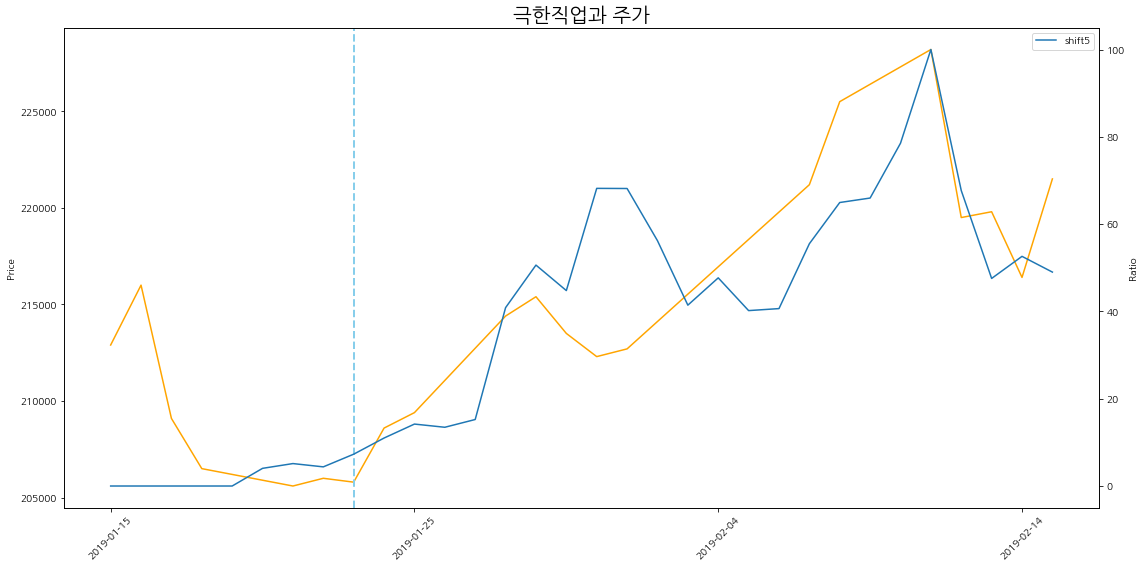

In [ ]:
  xtic=np.arange(0,len(shiftall.index),step=10)
  xdays=[shiftall.index[i] for i in xtic]

  sdf=shiftall['shift5']
  ptitle='극한직업과 주가'
  plt.rcParams["figure.figsize"] = (16,8)
  fig, ax1 = plt.subplots()

  # 주가 그래프
  ax1.plot(shiftall['CLOSEP'],c='orange')
  pos='2019-01-23'
  ax1.axvline(x=pos,label='개봉', c="skyblue", linestyle='--',  linewidth=2) 
  ax1.set_ylabel('Price')
  plt.xticks(xtic, rotation=45)

  # 네이버 DataLab 검색량 그래프
  ax2 = ax1.twinx()
  ax2.set_ylabel('Ratio')
  sdf.plot(ax=ax2)

  # 그래프 레이아웃 설정
  plt.title(ptitle, fontdict={'fontsize':20})
  plt.legend()
  fig.tight_layout()
  plt.show()

- 5일을 shift한 후 상관관계를 보니 약 81%롤 상승했다.
- shift한 데이터를 그래프로 확인하니 주가 그래프와 검색량 그래프가 비슷하게 간다.
- 영화의 파급력이 약 5일 이후에 나타나는 걸 확인할 수 있다.

## 6.3. shiftGraph 함수 정의
-  shift 데이터 시각화 함수 정의

In [ ]:
def shiftGraph(shiftall, baseCol, ptitle= 'shift 결과', axvpos='2019-01-23', textpos=20, xstep=10):

  xtic=np.arange(0,len(shiftall.index),step=10)
  xdays=[shiftall.index[i] for i in xtic]

  sdf=shiftall['shift_'+baseCol]

  plt.rcParams["figure.figsize"] = (16,8)
  fig, ax1 = plt.subplots()

  # 주가 그래프
  ax1.plot(shiftall['CLOSEP'],c='orange')
  pos=axvpos
  ax1.axvline(x=pos,label='개봉', c="skyblue", linestyle='--',  linewidth=2) 
  ax1.set_ylabel('Price')
  plt.xticks(xtic, rotation=45)

  # 네이버 DataLab 검색량 그래프
  ax2 = ax1.twinx()
  ax2.set_ylabel('Ratio')
  sdf.plot(ax=ax2)

  # 그래프 레이아웃 설정
  plt.title(ptitle, fontdict={'fontsize':20})
  plt.legend()
  fig.tight_layout()
  plt.show()

          CLOSEP      극한직업
CLOSEP  1.000000  0.390641
극한직업    0.390641  1.000000
--------------------------------------------------
             CLOSEP  shift_극한직업
CLOSEP      1.00000     0.81211
shift_극한직업  0.81211     1.00000
--------------------------------------------------


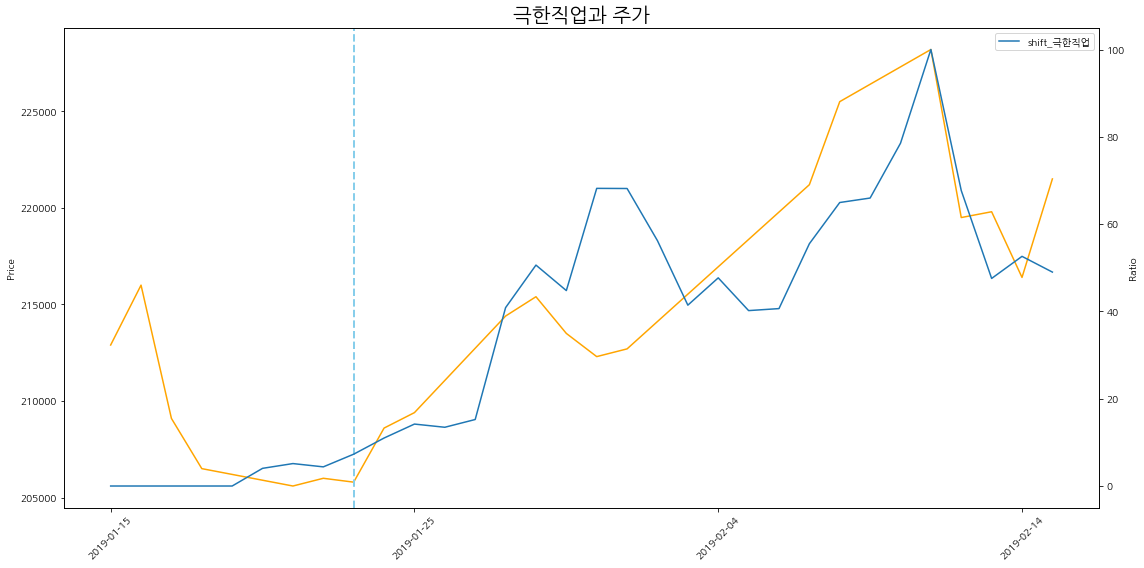

In [ ]:
keywords = [['극한직업'],['사바하'],['걸캅스'],['나쁜녀석들'],['백두산']]
baseCol='극한직업'
shiftday=5

# 기존 정보의 상관분석 - 효과적음
alldf = MyDBLab(keywords,'2019-01-15','2019-02-15','date','CJENM')
checkdf = alldf[['CLOSEP',baseCol]]
print(checkdf.corr())

# 쉬프트 정보 작성
checkdf.columns=['CLOSEP','shift_'+baseCol]
shiftdf=checkdf['shift_'+baseCol].shift(shiftday,fill_value=0)

# 기존데이터와 병합
shiftall=pd.merge(alldf,shiftdf,how="inner",left_index=True,right_index=True)
shiftall.head(10)
check5=shiftall[['CLOSEP','shift_'+baseCol]]

# 새로운 상관분석 실시
print('-'*50)
print(check5.corr())
print('-'*50)


# 시각화
shiftGraph(shiftall,baseCol,ptitle='극한직업과 주가',axvpos='2019-01-23', textpos=50)

In [ ]:
MyDBLab(keywords,'2019-01-20','2019-03-20','date','CJENM')

,SDAY,OPENP,HIGHP,LOWP,CLOSEP,VOL,극한직업,사바하,걸캅스,나쁜녀석들,백두산
period,,,,,,,,,,,
2019-01-20,NaN,NaN,NaN,NaN,NaN,NaN,14.18881,1.20624,0.01565,0.25396,0.16360
2019-01-21,20190121.0,205900.000000,208100.000000,204300.000000,205600.000000,51036.000000,13.45806,0.96437,0.02162,0.25138,0.15876
2019-01-22,20190122.0,205500.000000,206100.000000,203500.000000,206000.000000,33588.000000,15.23499,0.74397,0.01726,0.21765,0.17441
2019-01-23,20190123.0,205500.000000,205900.000000,203400.000000,205800.000000,48354.000000,40.86066,0.58633,0.02145,0.22717,0.22717
2019-01-24,20190124.0,205300.000000,208600.000000,203800.000000,208600.000000,49717.000000,50.60997,0.54003,0.01645,0.22040,0.17135
2019-01-25,20190125.0,207400.000000,212300.000000,206100.000000,209400.000000,47266.000000,44.77352,1.64462,0.01742,0.20281,0.16231
2019-01-26,20190126.0,209166.666667,213300.000000,207666.666667,211066.666667,56662.000000,68.18710,0.72009,0.01645,0.24718,0.15311
2019-01-27,20190127.0,210933.333333,214300.000000,209233.333333,212733.333333,66058.000000,68.15644,0.61134,0.01500,0.27993,0.14440
2019-01-28,20190128.0,212700.000000,215300.000000,210800.000000,214400.000000,75454.000000,56.19940,0.65975,0.01468,0.26557,0.16973


          CLOSEP       사바하
CLOSEP  1.000000  0.337861
사바하     0.337861  1.000000
--------------------------------------------------
             CLOSEP  shift_사바하
CLOSEP     1.000000   0.537253
shift_사바하  0.537253   1.000000
--------------------------------------------------


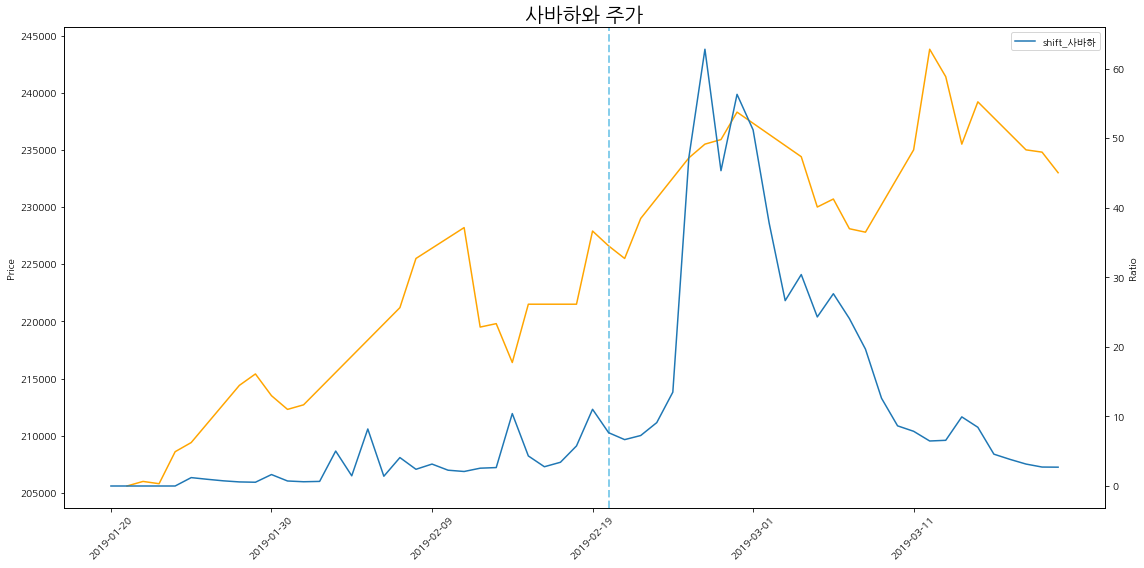

In [ ]:
baseCol='사바하'
shiftday=5

# 기존 정보의 상관분석 - 효과적음
alldf = MyDBLab(keywords,'2019-01-20','2019-03-20','date','CJENM')
checkdf = alldf[['CLOSEP',baseCol]]
print(checkdf.corr())

# 쉬프트 정보 작성
checkdf.columns=['CLOSEP','shift_'+baseCol]
shiftdf=checkdf['shift_'+baseCol].shift(shiftday,fill_value=0)

# 기존데이터와 병합
shiftall=pd.merge(alldf,shiftdf,how="inner",left_index=True,right_index=True)
shiftall.head(10)
check5=shiftall[['CLOSEP','shift_'+baseCol]]

# 새로운 상관분석 실시
print('-'*50)
print(check5.corr())
print('-'*50)


# 시각화
shiftGraph(shiftall,baseCol,ptitle='사바하와 주가',axvpos='2019-02-20', textpos=50)